In [0]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pickle
import glob
from __future__ import print_function, division
from music21 import converter, instrument, note, chord, stream
from keras.layers import Input, Dense, Reshape, Dropout, CuDNNLSTM, Bidirectional
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import np_utils

def get_notes():
  
    #Obtenemos las notas y acordes de los archivos midi
    notes = []

    #convertimos para cada archivo
    for file in glob.glob("*.mid"):
        midi = converter.parse(file)


        notes_to_parse = None

        # el archivo tiene parte de instrumentos
        try: 
            s2 = instrument.partitionByInstrument(midi)
            notes_to_parse = s2.parts[0].recurse() 
        except: # file has notes in a flat structure
            notes_to_parse = midi.flat.notes
            
        for element in notes_to_parse:
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder))

    return notes

def prepare_sequences(notes, n_vocab):
  
    # Preparamos las secuencias utilizadsa para red neuronal
    sequence_length = 100

    # Obtenemos todos los tonos
    pitchnames = sorted(set(item for item in notes))

    # Se crea un diccionario para mapear los tonos con numeros
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    network_input = []
    network_output = []

    # Crea una secuencia de entradas y sus salidas correspondientes
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        network_output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    # Convertimos las entradas a un formato compatible con las capas LSTM
    network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    
    # Normalizamos las entradas de -1 a 1
    network_input = (network_input - float(n_vocab)/2) / (float(n_vocab)/2)
    network_output = np_utils.to_categorical(network_output)

    return (network_input, network_output)

  
def generate_notes(model, network_input, n_vocab):
  
    #Generacion de notas desde la red neuronal
    
    # escogemos una secuencia aleatoria de entrada como punto de partida para la prediccion
    start = numpy.random.randint(0, len(network_input)-1)
    
    # obtenemos los tonos y los guardamos en un diccionario
    pitchnames = sorted(set(item for item in notes))
    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

    pattern = network_input[start]
    prediction_output = []

    # generamos 500 notas
    for note_index in range(500):
        prediction_input = numpy.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)

        prediction = model.predict(prediction_input, verbose=0)

        index = numpy.argmax(prediction)
        result = int_to_note[index]
        prediction_output.append(result)
        
        pattern = numpy.append(pattern,index)
        
        pattern = pattern[1:len(pattern)]

    return prediction_output
  
def create_midi(prediction_output, filename):
    
    #Convertimos la salida de la prediccion en notas y desde esas notas creamos
    #archivo midi
    
    offset = 0
    output_notes = []

    # Basados en los valores generados del modelos, creamos notas y acordes
    
    for item in prediction_output:
        pattern = item[0]
        # acorde
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # notas
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # Incrementamos el offset
        offset += 0.5

    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp='{}.mid'.format(filename))

class GAN():
    def __init__(self, rows):
        self.seq_length = rows
        self.seq_shape = (self.seq_length, 1)
        self.latent_dim = 1000
        self.disc_loss = []
        self.gen_loss =[]
        
        optimizer = Adam(0.0002, 0.5)

        # Construimos al discriminador
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        # Construimos al generador
        self.generator = self.build_generator()

        # The generator takes noise as input and generates note sequences
        z = Input(shape=(self.latent_dim,))
        generated_seq = self.generator(z)

        # En el modelo combinado solo entrenaremos al generador, el discriminador sera por separado
        self.discriminator.trainable = False

        
        validity = self.discriminator(generated_seq)

        
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_discriminator(self):

        model = Sequential()
        model.add(CuDNNLSTM(512, input_shape=self.seq_shape, return_sequences=True))
        model.add(Bidirectional(CuDNNLSTM(512)))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        seq = Input(shape=self.seq_shape)
        validity = model(seq)

        return Model(seq, validity)
      
    def build_generator(self):

        model = Sequential()
        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.seq_shape), activation='tanh'))
        model.add(Reshape(self.seq_shape))
        model.summary()
        
        noise = Input(shape=(self.latent_dim,))
        seq = model(noise)

        return Model(noise, seq)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Cargamos y convertimos la data
        notes = get_notes()
        n_vocab = len(set(notes))
        X_train, y_train = prepare_sequences(notes, n_vocab)

        
        real = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        # Entrenamos al modelo
        for epoch in range(epochs):

            # Entrenamos al discriminador
            # Seleccion de un lote random
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            real_seqs = X_train[idx]


            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new note sequences
            gen_seqs = self.generator.predict(noise)

            # Entrenando al discriminador
            d_loss_real = self.discriminator.train_on_batch(real_seqs, real)
            d_loss_fake = self.discriminator.train_on_batch(gen_seqs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            #  Entrenando al generador
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            
            g_loss = self.combined.train_on_batch(noise, real)

            if epoch % sample_interval == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.disc_loss.append(d_loss[0])
                self.gen_loss.append(g_loss)
        
        self.generate(notes)
        self.plot_loss()
        
    def generate(self, input_notes):
        # Obtiene los tipos de tonos y los almacena en un diccionario
        notes = input_notes
        pitchnames = sorted(set(item for item in notes))
        int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
        
        # Usa un ruido random para generar secuencias
        noise = np.random.normal(0, 1, (1, self.latent_dim))
        predictions = self.generator.predict(noise)
        
        pred_notes = [x*242+242 for x in predictions[0]]
        pred_notes = [int_to_note[int(x)] for x in pred_notes]
        
        create_midi(pred_notes, 'gan_final')
        
    def plot_loss(self):
        plt.plot(self.disc_loss, c='red')
        plt.plot(self.gen_loss, c='blue')
        plt.title("GAN Loss per Epoch")
        plt.legend(['Discriminator', 'Generator'])
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.savefig('GAN_Loss_per_Epoch_final.png', transparent=True)
        plt.show()

Using TensorFlow backend.





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 100, 512)          1054720   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1024)              4202496   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)             

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.697849, acc.: 23.33%] [G loss: 0.690551]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.675534, acc.: 60.00%] [G loss: 0.690323]
2 [D loss: 0.658047, acc.: 66.67%] [G loss: 0.693007]
3 [D loss: 0.617700, acc.: 70.00%] [G loss: 0.702484]
4 [D loss: 0.522021, acc.: 76.67%] [G loss: 0.822579]
5 [D loss: 0.323536, acc.: 90.00%] [G loss: 1.499870]
6 [D loss: 0.137812, acc.: 96.67%] [G loss: 2.146304]
7 [D loss: 0.245169, acc.: 96.67%] [G loss: 4.280557]
8 [D loss: 0.280924, acc.: 90.00%] [G loss: 2.521831]
9 [D loss: 0.106895, acc.: 93.33%] [G loss: 5.221041]
10 [D loss: 0.037402, acc.: 96.67%] [G loss: 8.267805]
11 [D loss: 0.929299, acc.: 93.33%] [G loss: 5.753031]
12 [D loss: 0.057581, acc.: 96.67%] [G loss: 3.617956]
13 [D loss: 0.083197, acc.: 100.00%] [G loss: 5.723338]
14 [D loss: 0.151662, acc.: 93.33%] [G loss: 6.123492]
15 [D loss: 0.355946, acc.: 86.67%] [G loss: 1.635143]
16 [D loss: 0.243271, acc.: 96.67%] [G loss: 2.214944]
17 [D loss: 0.188377, acc.: 93.33%] [G loss: 4.127961]
18 [D loss: 0.326822, acc.: 83.33%] [G loss: 2.247049]
19 [D loss: 0.1837

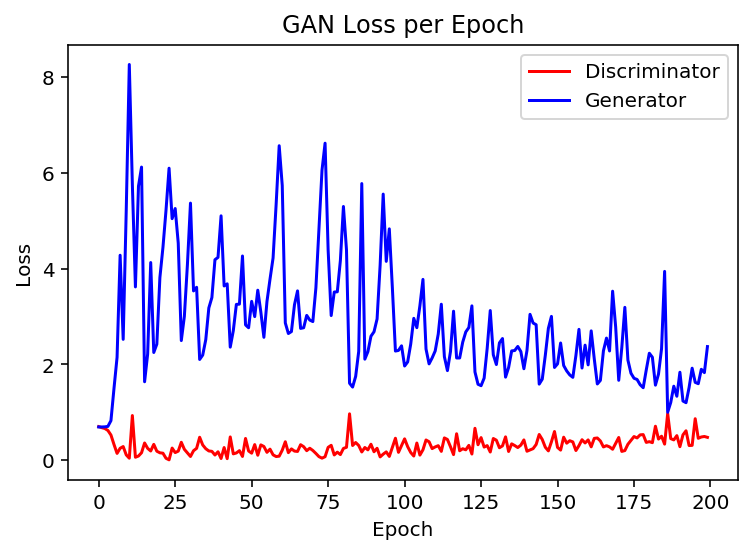

In [0]:
gan = GAN(rows=100)    
gan.train(epochs=200, batch_size=15, sample_interval=1)

In [0]:
from google.colab import files
files.download('gan_final.mid')